<h1>LSTM + MLPNN model</h1>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #only show errors (hide INFO and WARNING)

import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

random.seed(1234)   
np.random.seed(1234)


In [2]:
def plot_loss_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

def plot_accuracy_history(history):
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['accuracy'] + 1)))
  plt.plot(history['accuracy'], label="training", marker='o')
  plt.plot(history['val_accuracy'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [19]:
def build_model(number_of_features, dense_layers_unit_array=[], learningRate=0.001,
                activation="relu", isBatchNormalized=False, dropOutRate=0,
                startWithBatchNormalized=False,optimizer="Adam",
                lstm_layers_unit_array=[]
               ):
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    
    strategy = tf.distribute.MirroredStrategy(devices=None)
    print('Number of GPU/CPU: {}'.format(strategy.num_replicas_in_sync))
    
    print("num_of_dense_layers:",len(dense_layers_unit_array))
    
    for i, dense_layer_unit in enumerate(dense_layers_unit_array):       
        print("dense_layer["+str(i)+"]; unit:"+str(dense_layer_unit))      
        
        
    print("num_of_lstm_layers:",len(lstm_layers_unit_array))    
    for i, lstm_layer_unit in enumerate(lstm_layers_unit_array):       
        print("lstm_layer_unit["+str(i)+"]; unit:"+str(lstm_layer_unit))
       
    print("learningRate:",learningRate)
    print("isBatchNormalized:",isBatchNormalized,"; dropOutRate:",dropOutRate)
    
    startWithBatchNormalized = startWithBatchNormalized or optimizer == "SGD"
    print("startWithBatchNormalized:",startWithBatchNormalized)
    print("optimizer:",optimizer,"; activation:",activation)
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)     
    np.random.seed(1234)
    random.seed(1234)
    
    with strategy.scope():   
        model = Sequential() 
        
        if startWithBatchNormalized:
            model.add(BatchNormalization())
        
        # Add LSTM layers
        for i, lstm_layer_unit in enumerate(lstm_layers_unit_array):    
            model.add(LSTM(lstm_layer_unit, return_sequences=True))

        if len(lstm_layers_unit_array) > 0:    
            model.add(Flatten()) 
        
        # Add Dense layers
        for i, dense_layer_unit in enumerate(dense_layers_unit_array):
            model.add(tf.keras.layers.Dense(
                units=dense_layer_unit,
                name='fc_'+str(i), 
                activation=activation))
            if isBatchNormalized:
                model.add(BatchNormalization())
            if dropOutRate > 0:
                model.add(Dropout(dropOutRate))

        model.add(Dense(4))
        model.add(Activation('softmax'))   

        model.build(input_shape=(None, number_of_features, 1))

        if optimizer=="Adam":
            opt = keras.optimizers.Adam(learning_rate=learningRate)
        elif optimizer=="SGD":
            opt = keras.optimizers.SGD(learning_rate=learningRate)
        else:
            opt = keras.optimizers.Adam(learning_rate=learningRate)    
        

        model.compile(optimizer=opt,
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])    
    
    return model
    

In [4]:
def train_and_test_model(train_dataset, validate_dataset, x_train,
                         save_to, epoch = 2,
                         dense_layers_unit_array=[],
                         patience=10, epoch_denominator=10.,
                         isConstantLearningRate=False, learningRate=0.001,
                         activation="relu", isBatchNormalized=False,dropOutRate=0,
                         startWithBatchNormalized=False,optimizer="Adam",
                         lstm_layers_unit_array=[]
                        ):
    
    print("epoch:",epoch, "; epoch_denominator:",epoch_denominator) 
    print("patience:",patience,"; isConstantLearningRate:", isConstantLearningRate) 
    
    model = build_model(x_train.shape[1],
                        dense_layers_unit_array=dense_layers_unit_array, learningRate=learningRate,
                        activation=activation, isBatchNormalized=isBatchNormalized, dropOutRate=dropOutRate,
                        startWithBatchNormalized=startWithBatchNormalized,optimizer=optimizer,
                        lstm_layers_unit_array=lstm_layers_unit_array
                       )

    model.summary()
    tf.keras.utils.plot_model(model)  
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

    if isConstantLearningRate:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate)        
    else:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate * np.exp(-epoch / epoch_denominator))

    history = model.fit(train_dataset,
                        epochs=epoch,
                        validation_data=validate_dataset,
                        shuffle=True,
                        callbacks=[es,lr_schedule])

    history_data = pd.DataFrame(history.history)
    plot_loss_history(history_data)
    plot_accuracy_history(history_data)

    # test model
    test_results = model.evaluate(test_dataset)
    print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

    # show classification report
    y_predict = np.array(model.predict(test_dataset))
    y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
    print(classification_report(y_test, y_predict))
    
    print("Confusion matrix")
    print(confusion_matrix(y_test.values.argmax(axis=1), np.argmax(y_predict, axis=1)))

In [5]:
dataset = pd.read_csv('csv/out_gameemo.csv',  sep=',')

print('Shape of data: ', dataset.shape)

Shape of data:  (40071, 3739)


In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

init_df = dataset.copy()

#HA_PV = high arousal, positive valence
#HA_NV = high arousal, negative valence
#LA_NV = low arousal, negative valence
#LA_PV = low arousal, positive valance
label_map = {1:"HA_PV", 2:"HA_NV", 3:"LA_NV", 4:"LA_PV"}

init_df["Label"] = init_df["Label"].map(label_map)


features = init_df.iloc[:, :-1]
label = init_df.iloc[:, -1:]

print('Shape of data: ', init_df.shape)
print('features.shape: ', features.shape)
print('label.shape: ', label.shape)

#######

y = label
X = features

X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.6, random_state=48)

X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, train_size=0.5, random_state=48)

X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_validate = np.array(X_validate).reshape((X_validate.shape[0],X_test.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))

y_train = pd.get_dummies(y_train)
y_validate = pd.get_dummies(y_validate)
y_test = pd.get_dummies(y_test)

print("y_train:")
print(y_train[:5])

#######
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validate_dataset = tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_dataset.with_options(options)
validate_dataset.with_options(options)
test_dataset.with_options(options)

        
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
validate_dataset = validate_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)



Shape of data:  (40071, 3739)
features.shape:  (40071, 3738)
label.shape:  (40071, 1)
y_train:
       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
13079            1            0            0            0
37831            1            0            0            0
23516            0            0            1            0
10630            0            1            0            0
36071            0            0            1            0


<h3>Manual runs to get a feel of the hyperparameters</h3>
Will use the best LSTM model with 78.23% accuracy and build on that with Dense layers. </br>
Dense layer for some reason doesn't work with activation 'tanh', use 'relu' instead.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_lstm_layers: 1
lstm_layer_unit[0]; unit:15
learningRate: 0.001
isBatchNormalized: True ; dropOutRate: 0.2
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3738, 15)          1020      
_________________________________________________________________
flatten (Flatten)            (None, 56070)             0         
_________________________________________________________________
fc_0 (Dense)                 (None, 512)               28708352  
_______________________________________

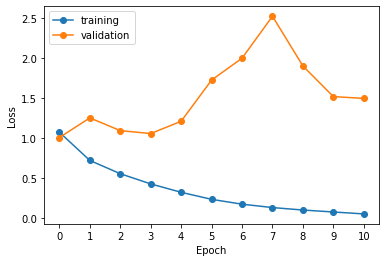

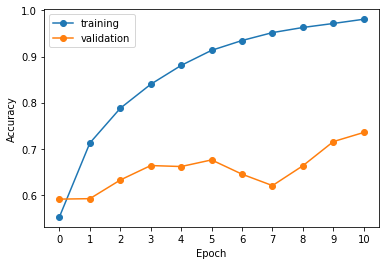

251/251 [==============================] - 12s 45ms/step - loss: 1.4670 - accuracy: 0.7390 - precision: 0.7421 - recall: 0.7369

Test Acc. 73.90%
              precision    recall  f1-score   support

           0       0.87      0.55      0.67      1978
           1       0.76      0.78      0.77      1957
           2       0.68      0.92      0.78      2069
           3       0.72      0.71      0.71      2011

   micro avg       0.74      0.74      0.74      8015
   macro avg       0.76      0.74      0.73      8015
weighted avg       0.76      0.74      0.73      8015
 samples avg       0.74      0.74      0.74      8015

Confusion matrix
[[1084  321  294  279]
 [  77 1524  176  180]
 [  25   44 1895  105]
 [  65  123  403 1420]]


In [28]:

train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.001,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.2,
                     activation="relu",
                     lstm_layers_unit_array=[15],
                     isBatchNormalized=True
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_lstm_layers: 1
lstm_layer_unit[0]; unit:15
learningRate: 0.001
isBatchNormalized: True ; dropOutRate: 0.2
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3738, 15)          1020      
_________________________________________________________________
flatten (Flatten)            (None, 56070)             0         
_________________________________________________________________
fc_0 (Dense)                 (None, 512)               28708352  
________________________________________

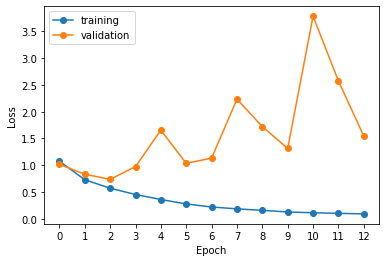

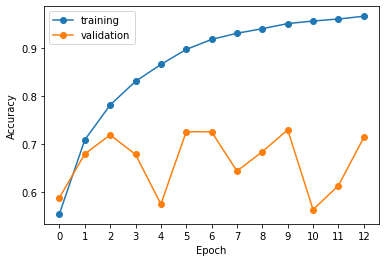

251/251 [==============================] - 12s 45ms/step - loss: 1.5191 - accuracy: 0.7233 - precision: 0.7258 - recall: 0.7195

Test Acc. 72.33%
              precision    recall  f1-score   support

           0       0.84      0.58      0.69      1978
           1       0.78      0.71      0.74      1957
           2       0.87      0.71      0.78      2069
           3       0.56      0.89      0.69      2011

   micro avg       0.72      0.72      0.72      8015
   macro avg       0.76      0.72      0.73      8015
weighted avg       0.76      0.72      0.73      8015
 samples avg       0.72      0.72      0.72      8015

Confusion matrix
[[1151  244   88  495]
 [ 106 1387   52  412]
 [  47   69 1467  486]
 [  70   75   74 1792]]


In [29]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.001,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.2,
                     activation="relu",
                     lstm_layers_unit_array=[15],
                     isBatchNormalized=True,
                     isConstantLearningRate=True
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 2
dense_layer[0]; unit:100
dense_layer[1]; unit:100
num_of_lstm_layers: 1
lstm_layer_unit[0]; unit:15
learningRate: 0.001
isBatchNormalized: True ; dropOutRate: 0.2
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3738, 15)          1020      
_________________________________________________________________
flatten (Flatten)            (None, 56070)             0         
_________________________________________________________________
fc_0 (Dense)                 (None, 100)               5607100   
______________

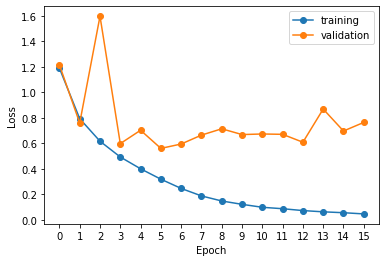

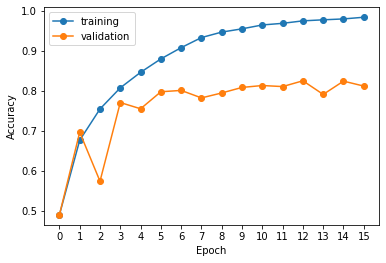

251/251 [==============================] - 12s 45ms/step - loss: 0.7477 - accuracy: 0.8191 - precision: 0.8238 - recall: 0.8140

Test Acc. 81.91%
              precision    recall  f1-score   support

           0       0.84      0.74      0.79      1978
           1       0.72      0.92      0.81      1957
           2       0.92      0.83      0.87      2069
           3       0.84      0.78      0.81      2011

   micro avg       0.82      0.82      0.82      8015
   macro avg       0.83      0.82      0.82      8015
weighted avg       0.83      0.82      0.82      8015
 samples avg       0.82      0.82      0.82      8015

Confusion matrix
[[1472  356   36  114]
 [  81 1810   17   49]
 [  78  135 1708  148]
 [ 120  229   87 1575]]


In [30]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[100,100], learningRate=0.001,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.2,
                     activation="relu",
                     lstm_layers_unit_array=[15],
                     isBatchNormalized=True
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 3
dense_layer[0]; unit:100
dense_layer[1]; unit:100
dense_layer[2]; unit:100
num_of_lstm_layers: 1
lstm_layer_unit[0]; unit:15
learningRate: 0.001
isBatchNormalized: True ; dropOutRate: 0.2
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3738, 15)          1020      
_________________________________________________________________
flatten (Flatten)            (None, 56070)             0         
_________________________________________________________________
fc_0 (Dense)                 (None, 100)               

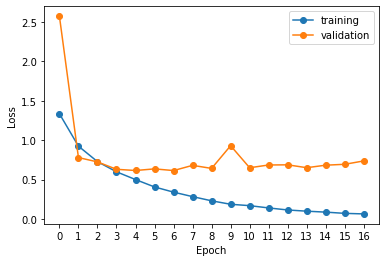

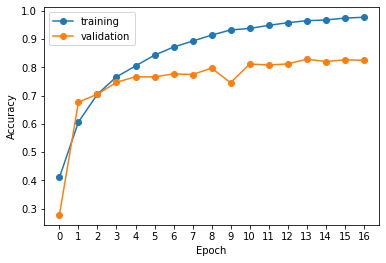

251/251 [==============================] - 12s 45ms/step - loss: 0.7259 - accuracy: 0.8307 - precision: 0.8346 - recall: 0.8273

Test Acc. 83.07%
              precision    recall  f1-score   support

           0       0.79      0.84      0.81      1978
           1       0.86      0.79      0.82      1957
           2       0.88      0.87      0.87      2069
           3       0.80      0.82      0.81      2011

   micro avg       0.83      0.83      0.83      8015
   macro avg       0.83      0.83      0.83      8015
weighted avg       0.83      0.83      0.83      8015
 samples avg       0.83      0.83      0.83      8015

Confusion matrix
[[1667  136   62  113]
 [ 223 1545   64  125]
 [  67   37 1793  172]
 [ 161   80  117 1653]]


In [31]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[100,100,100], learningRate=0.001,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.2,
                     activation="relu",
                     lstm_layers_unit_array=[15],
                     isBatchNormalized=True
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 3
dense_layer[0]; unit:100
dense_layer[1]; unit:100
dense_layer[2]; unit:100
num_of_lstm_layers: 1
lstm_layer_unit[0]; unit:15
learningRate: 0.001
isBatchNormalized: True ; dropOutRate: 0.5
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3738, 15)          1020      
_________________________________________________________________
flatten (Flatten)            (None, 56070)             0         
_________________________________________________________________
fc_0 (Dense)                 (None, 100)               

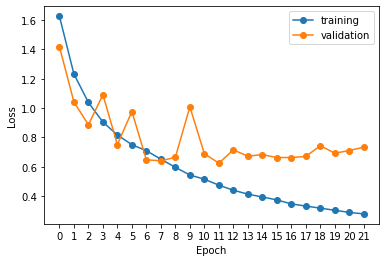

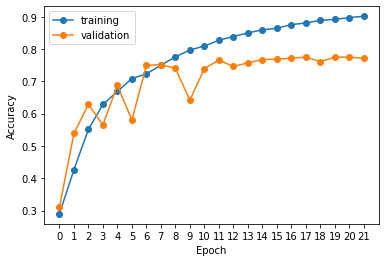

251/251 [==============================] - 12s 45ms/step - loss: 0.6969 - accuracy: 0.7871 - precision: 0.7958 - recall: 0.7762

Test Acc. 78.71%
              precision    recall  f1-score   support

           0       0.81      0.71      0.76      1978
           1       0.80      0.79      0.79      1957
           2       0.87      0.81      0.84      2069
           3       0.70      0.84      0.76      2011

   micro avg       0.79      0.79      0.79      8015
   macro avg       0.79      0.79      0.79      8015
weighted avg       0.79      0.79      0.79      8015
 samples avg       0.79      0.79      0.79      8015

Confusion matrix
[[1401  220   78  279]
 [ 151 1550   57  199]
 [  61   77 1676  255]
 [ 108   97  124 1682]]


In [32]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[100,100,100], learningRate=0.001,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0.5,
                     activation="relu",
                     lstm_layers_unit_array=[15],
                     isBatchNormalized=True
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 3
dense_layer[0]; unit:100
dense_layer[1]; unit:100
dense_layer[2]; unit:100
num_of_lstm_layers: 1
lstm_layer_unit[0]; unit:15
learningRate: 0.001
isBatchNormalized: True ; dropOutRate: 0
startWithBatchNormalized: False
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3738, 15)          1020      
_________________________________________________________________
flatten (Flatten)            (None, 56070)             0         
_________________________________________________________________
fc_0 (Dense)                 (None, 100)               56

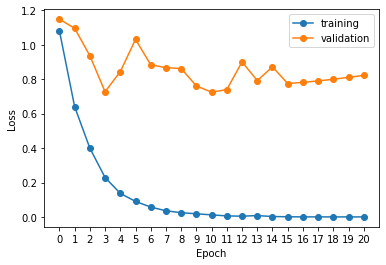

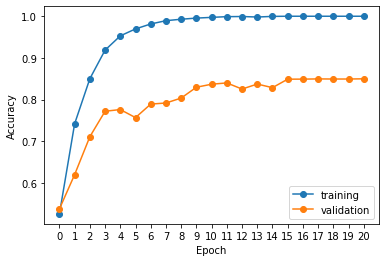

251/251 [==============================] - 12s 46ms/step - loss: 0.7991 - accuracy: 0.8588 - precision: 0.8606 - recall: 0.8578

Test Acc. 85.88%
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1978
           1       0.86      0.86      0.86      1957
           2       0.89      0.89      0.89      2069
           3       0.85      0.85      0.85      2011

   micro avg       0.86      0.86      0.86      8015
   macro avg       0.86      0.86      0.86      8015
weighted avg       0.86      0.86      0.86      8015
 samples avg       0.86      0.86      0.86      8015

Confusion matrix
[[1659  154   70   95]
 [ 150 1678   44   85]
 [  68   46 1840  115]
 [ 114   71  120 1706]]


In [33]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[100,100,100], learningRate=0.001,
                     startWithBatchNormalized=False, optimizer="Adam",dropOutRate=0,
                     activation="relu",
                     lstm_layers_unit_array=[15],
                     isBatchNormalized=True
                    )

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 3
dense_layer[0]; unit:100
dense_layer[1]; unit:100
dense_layer[2]; unit:100
num_of_lstm_layers: 1
lstm_layer_unit[0]; unit:15
learningRate: 0.001
isBatchNormalized: True ; dropOutRate: 0
startWithBatchNormalized: True
optimizer: Adam ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
_________________________________________________________________
lstm (LSTM)                  (None, 3738, 15)          1020      
_________________________________________________________________
flatten (Flatten)            (None, 56070)             0  

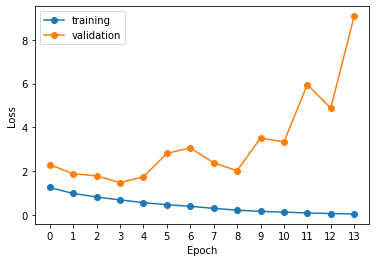

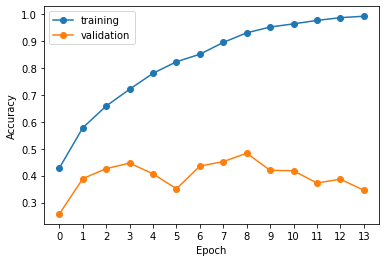

251/251 [==============================] - 12s 46ms/step - loss: 8.9961 - accuracy: 0.3432 - precision: 0.3434 - recall: 0.3424

Test Acc. 34.32%


In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[100,100,100], learningRate=0.001,
                     startWithBatchNormalized=True, optimizer="Adam",dropOutRate=0,
                     activation="relu",
                     lstm_layers_unit_array=[15],
                     isBatchNormalized=True
                    )

<h3>Perform hyperparam tuning using the LSTM + MLPNN model</h3>
Using the hyperparams from the best LSTM model, only hyper tune the Dense layers params. 

In [ ]:
number_of_features = X_train.shape[1]

def model_tuner(hp):
    print("number_of_features:", number_of_features)
    
    dense_layers_unit_array_size = hp.Int('dense_layers_unit_array_size', min_value=1, max_value=3, step=1)
    dense_layers_unit_array = []
    
    for i in range(dense_layers_unit_array_size):
        dense_layers_unit_array.append(hp.Int('dl_units_'+str(i), 
                                              min_value=64, max_value=640, step=64))
    
    lstm_layers_unit_array=[15]
    
    model = build_model(number_of_features, 
                dense_layers_unit_array=dense_layers_unit_array, 
                learningRate=hp.Choice('learningRate', values=[0.001, 0.01, 0.05, 0.1]),
                activation=hp.Choice('activation', values=["tanh", "relu"]), 
                isBatchNormalized=True, 
                dropOutRate=0.2,
                startWithBatchNormalized= False,      
                optimizer="Adam",
                lstm_layers_unit_array=lstm_layers_unit_array
                       )
    
    return model

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

epochs = 40
tuner = kt.Hyperband(model_tuner,
                     objective='val_accuracy',
                     max_epochs=epochs,
                     factor=3,
                     directory='.',
                     seed=1234,
                     project_name='eeg')


stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


tuner.search(train_dataset, 
             epochs=epochs, 
             validation_data=validate_dataset,
             shuffle=True,
             callbacks=[stop_early])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print("#### Hypertuning results:")

print("learningRate:",best_hps.get('learningRate'))
print("isBatchNormalized:",best_hps.get('isBatchNormalized'))
print("dropOutRate:",best_hps.get('dropOutRate'))

print("dense_layers_unit_array_size:",best_hps.get('dense_layers_unit_array_size'))
try:
    print("dl_units_0:",best_hps.get('dl_units_0'))
except:
    print("no dense layer 0")
try:
    print("dl_units_1:",best_hps.get('dl_units_1'))
except:
    print("no dense layer 1")
try:
    print("dl_units_2:",best_hps.get('dl_units_2'))
except:
    print("no dense layer 2")    
  

print("dropOutRate:",best_hps.get('dropOutRate'))

print("#########################################")
print("")


model = tuner.hypermodel.build(best_hps)
history = model.fit(train_dataset, 
             epochs=epochs, 
             validation_data=validate_dataset,
             shuffle=True,
             callbacks=[stop_early])

history_data = pd.DataFrame(history.history)
plot_loss_history(history_data)
plot_accuracy_history(history_data)

# test model
test_results = model.evaluate(test_dataset)
print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

# show classification report
y_predict = np.array(model.predict(test_dataset))
y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
print(classification_report(y_test, y_predict))

<h3>Conclusion</h3>

Hyperparam tuning on CNN: 78.23% accuracy </br>
num_of_dense_layers: 0 </br>
num_of_lstm_layers: 1 </br>
lstm_layer_unit[0]; unit:15 </br>
learningRate: 0.001 </br>
isBatchNormalized: True ; dropOutRate: 0.2 </br>
startWithBatchNormalized: False </br>
optimizer: Adam ; activation: tanh </br>
</br>

Manual tuning on CNN: 76.57% accuracy </br>
num_of_dense_layers: 0 </br>
num_of_lstm_layers: 1 </br>
lstm_layer_unit[0]; unit:256 </br>
learningRate: 0.001 </br>
isBatchNormalized: False ; dropOutRate: 0.5 </br>
startWithBatchNormalized: False </br>
optimizer: Adam ; activation: relu </br>